In [37]:
from fbprophet import Prophet
import altair as alt
import pandas as pd

alt.renderers.enable("notebook")

def fit_predict_model(dataframe,
                      interval_width = 0.9,
                      changepoint_range = 1,
                      changepoint_prior_scale=0.05
                     ):
    m = Prophet(daily_seasonality = "auto", yearly_seasonality = "auto", weekly_seasonality = "auto",
                seasonality_mode = 'additive',
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast, m


def detect_anomalies(forecast, threhold=0):
    forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    # forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper']-threhold, 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower']+threhold, 'anomaly'] = -1

    # anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'] + threhold) / forecast['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'] - threhold) / forecast['fact']

    return forecasted

def plot_anomalies(forecasted):
    
    max_y = max(forecasted["fact"])
    min_y = min(forecasted["fact"])
    print(min_y, max_y)
    if min_y < 100: # MA
        bias = 0.002
    else:
        bias = 10
    
    alt.data_transformers.disable_max_rows()
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color='#7FC97F').encode(
        x=alt.X('攻角',scale=alt.Scale(domain=(min(forecasted["攻角"]), max(forecasted["攻角"])))),
#         y=alt.Y('yhat_upper'),
#         y2=alt.Y('yhat_lower'),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly == 0]).mark_circle(size=15, opacity=0.7, color='Black').encode(
        x=alt.X('攻角',scale=alt.Scale(domain=(min(forecasted["攻角"]), max(forecasted["攻角"])))),
        y=alt.Y('fact', title="实际MA", scale=alt.Scale(domain=(min_y-bias, max_y+bias))),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    )

    anomalies = alt.Chart(forecasted[forecasted.anomaly != 0]).mark_circle(size=30, color='Red').encode(
        x=alt.X('攻角',scale=alt.Scale(domain=(min(forecasted["攻角"]), max(forecasted["攻角"])))),
        y=alt.Y('fact', title="实际MA", scale=alt.Scale(domain=(min_y-bias, max_y+bias))),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size=alt.Size('importance', legend=None)
    )
    return alt.layer(interval, fact, anomalies) \
        .properties(width=500, height=300) \
        .configure_title(fontSize=20)

In [38]:
import os
filenames = os.listdir("./data/origin/")
abnormal_filenames = ["5_0.1.csv", "6_0.2.csv", "7_0.2.csv", "8_0.2.csv", "9_0.1.csv", "10_0.2.csv"]
data = pd.read_csv("./data/origin/" + abnormal_filenames[1], encoding="gbk")
data1 = data[["实际MA"]]
data2 = data[["实际转速"]]
data1["ds"] = pd.date_range(start="2019-10-1", periods=data1.values.shape[0], freq="H")
data2["ds"] = pd.date_range(start="2019-10-1", periods=data1.values.shape[0], freq="H")
data1.rename(columns={"实际MA":"y"}, inplace=True)
data2.rename(columns={"实际转速":"y"}, inplace=True)
data1 = data1[["ds", "y"]]
data2 = data2[["ds", "y"]]
data1

D:\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ds,y
0,2019-10-01 00:00:00,0.70012
1,2019-10-01 01:00:00,0.70020
2,2019-10-01 02:00:00,0.70014
3,2019-10-01 03:00:00,0.70015
4,2019-10-01 04:00:00,0.70028
5,2019-10-01 05:00:00,0.70056
6,2019-10-01 06:00:00,0.70107
7,2019-10-01 07:00:00,0.70148
8,2019-10-01 08:00:00,0.70177
9,2019-10-01 09:00:00,0.70200


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


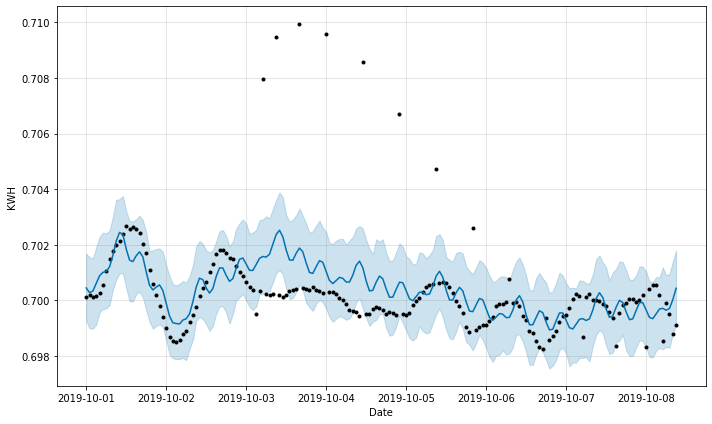

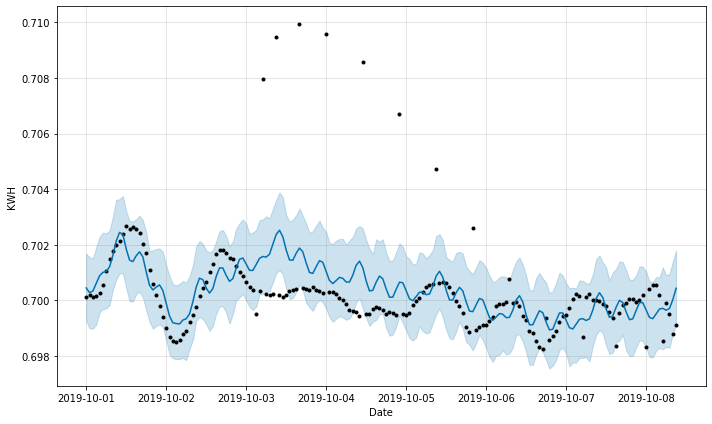

In [39]:
# data = pd.read_csv("./data/test_detect_anoms.csv")
# data.columns = ["ds", "y"]
forecast, model = fit_predict_model(data1, interval_width = 0.6, changepoint_range = 0.8, changepoint_prior_scale=0.005)

f = model.plot(forecast, xlabel='Date', ylabel='KWH')
f

In [6]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,2019-10-01 00:00:00,1.000911,1.000911,1.000911,0.998075,1.003151,-0.000410,-0.000410,-0.000410,-0.000410,-0.000410,-0.000410,0.0,0.0,0.0,1.000501,0.99991
1,2019-10-01 01:00:00,1.000879,1.000879,1.000879,0.997887,1.003026,-0.000373,-0.000373,-0.000373,-0.000373,-0.000373,-0.000373,0.0,0.0,0.0,1.000506,1.00018
2,2019-10-01 02:00:00,1.000847,1.000847,1.000847,0.997824,1.003140,-0.000364,-0.000364,-0.000364,-0.000364,-0.000364,-0.000364,0.0,0.0,0.0,1.000483,1.00026
3,2019-10-01 03:00:00,1.000814,1.000814,1.000814,0.997804,1.003063,-0.000346,-0.000346,-0.000346,-0.000346,-0.000346,-0.000346,0.0,0.0,0.0,1.000468,1.00040
4,2019-10-01 04:00:00,1.000782,1.000782,1.000782,0.998193,1.003209,-0.000217,-0.000217,-0.000217,-0.000217,-0.000217,-0.000217,0.0,0.0,0.0,1.000565,1.00060
5,2019-10-01 05:00:00,1.000749,1.000749,1.000749,0.998044,1.003453,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.0,0.0,0.0,1.000800,1.00083
6,2019-10-01 06:00:00,1.000717,1.000717,1.000717,0.998581,1.003771,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.0,0.0,0.0,1.001054,1.00100
7,2019-10-01 07:00:00,1.000685,1.000685,1.000685,0.998622,1.003733,0.000459,0.000459,0.000459,0.000459,0.000459,0.000459,0.0,0.0,0.0,1.001144,1.00117
8,2019-10-01 08:00:00,1.000652,1.000652,1.000652,0.998321,1.003447,0.000330,0.000330,0.000330,0.000330,0.000330,0.000330,0.0,0.0,0.0,1.000982,1.00131
9,2019-10-01 09:00:00,1.000620,1.000620,1.000620,0.998049,1.003277,0.000050,0.000050,0.000050,0.000050,0.000050,0.000050,0.0,0.0,0.0,1.000670,1.00147


# New heading

In [7]:
forecast1 = detect_anomalies(forecast, 0)
forecast1["攻角"] = data["攻角"]
forecast1

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance,攻角
0,2019-10-01 00:00:00,1.000911,1.000501,0.998075,1.003151,0.99991,0,0.0,-5.000
1,2019-10-01 01:00:00,1.000879,1.000506,0.997887,1.003026,1.00018,0,0.0,-4.950
2,2019-10-01 02:00:00,1.000847,1.000483,0.997824,1.003140,1.00026,0,0.0,-4.840
3,2019-10-01 03:00:00,1.000814,1.000468,0.997804,1.003063,1.00040,0,0.0,-4.752
4,2019-10-01 04:00:00,1.000782,1.000565,0.998193,1.003209,1.00060,0,0.0,-4.652
5,2019-10-01 05:00:00,1.000749,1.000800,0.998044,1.003453,1.00083,0,0.0,-4.548
6,2019-10-01 06:00:00,1.000717,1.001054,0.998581,1.003771,1.00100,0,0.0,-4.446
7,2019-10-01 07:00:00,1.000685,1.001144,0.998622,1.003733,1.00117,0,0.0,-4.352
8,2019-10-01 08:00:00,1.000652,1.000982,0.998321,1.003447,1.00131,0,0.0,-4.250
9,2019-10-01 09:00:00,1.000620,1.000670,0.998049,1.003277,1.00147,0,0.0,-4.146


0.9990899999999999 1.01349


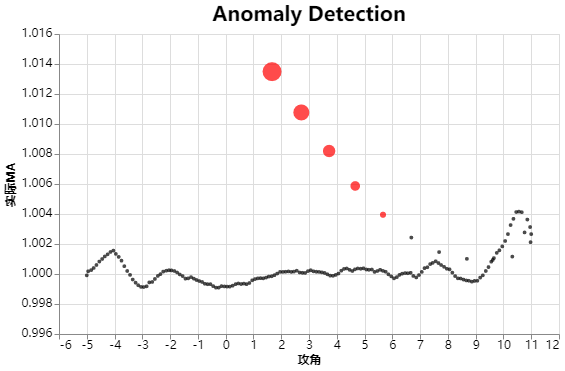

In [8]:
plot_anomalies(forecast1)